# Accessing the Dropbox API

This notebook contains:

1. instructions for getting a Dropbox API token,
2. wrapper code to access (a subset of) the Dropbox API,
3. code for importing data from and exporting data to a CSV file.

## Requirements

1. Register a new Dropbox app
2. Get an API token

An **application programming interface** (API) is how an app/service makes its functions and methods asvailabel to other apps and services. Dropbox is one such service that enables other app developers to access a user’s Dropbox and make changes (with the user’s permission).

In this notebook, you will access the Dropbox API through a `DBApi` class and its methods. To grant the `DBApi` permission to access your files and folders in Dropbox, you will generate a developer key.

You need to [register a Dropbox account](https://www.dropbox.com/register), if you do not have one yet.

## 1 Register a new Dropbox app

Go to the Dropbox [Developer Apps page](https://www.dropbox.com/developers/apps). Click on [**Create app**](https://www.dropbox.com/developers/apps/create).

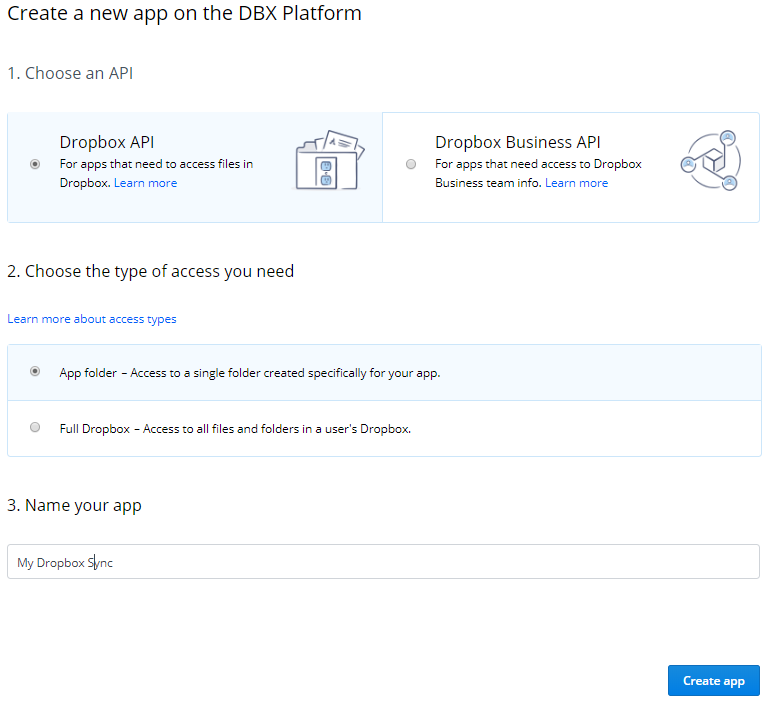

Name your app anything you like.

Click on **Create app**.

## 2 Get an API token

Go to the [Developer Apps page](https://www.dropbox.com/developers/apps/create) again, and click on your newly created app.

Scroll down to the section titled **OAuth 2**.

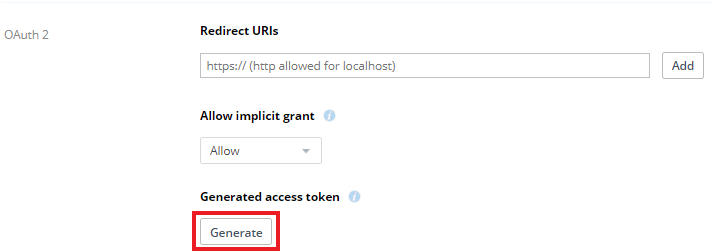

Click on **Generate**, and copy the API token that you get.

You will need this API token later.

Run the last code cell to generate the Python module `dropbox_api` which will be needed for your syncing app. Verify that the file `dropbox_api.py` is successfully generated in the same directory as this file.

Then go to [Syncing files to Dropbox](sync-to-dropbox.ipynb) to get started.

In [ ]:
# Do not change the code in this cell.
# It is needed for the main project.

# Dropbox API class with required methods
import requests
import json
from pathlib import Path


class APIError(Exception):
    '''Custom exception for any response status that is not 200'''
    def __init__(self, resp, msg=None):
        self.response = resp
        print(f'{resp.status_code}: {resp.reason}\n'
              f'Error message: {msg}')


class RateLimitError(APIError):
    '''Custom exception for requests that bump into the rate limit'''
    def __init__(self, resp, msg=None):
        self.response = resp
        print(f'{resp.status_code}: {resp.reason}')
        try:
            print(resp.json())
        except Exception:
            print('No json response body or invalid.')
        if 'Retry-After' in resp.headers:
            print(f'Retry-After: {resp.headers["Retry-After"]}')
        print(kwargs['msg'])


class DBApi:
    '''
    A wrapper for the Dropbox HTTP API.

    Usage:
    db = DBApi('your-token-here')
    db.list_folder("")
    db.delete(...)
    db.create_folder(...)
    db.upload_file(...)

    See the help docstring of each method for more details.
    '''
    token = None
    headers = None
    root = '/'
    _do = {'list': 'https://api.dropboxapi.com/2/files/list_folder',
           'latest':
           'https://api.dropboxapi.com/2/files/list_folder/get_latest_cursor',
           'delete': 'https://api.dropboxapi.com/2/files/delete_v2',
           'create': 'https://api.dropboxapi.com/2/files/create_folder_v2',
           'upload': 'https://content.dropboxapi.com/2/files/upload',
           }

    def __init__(self, token):
        self.token = token
        self.headers = {'Content-Type': 'application/json',
                        'Authorization': f'Bearer {self.token}'}

    def upload_headers(self, path):
        params = {'path': path,
                  'mode': 'overwrite',
                  }
        return {'Content-Type': 'application/octet-stream',
                                'Authorization': f'Bearer {self.token}',
                                'Dropbox-API-Arg': json.dumps(params)
                }

    def list_folder(self, path='', **kwargs) -> dict:
        '''
        Gets the directory listing at `path`. If `path` is not specified,
        the listing at the root directory is returned.

        Usage:
        DBApi.list_folder(path)

        Response:
        {'entries': list,
         'cursor': str,
         'has_more': bool,
        }
        '''
        cursor = kwargs.get('cursor', None)
        if cursor is not None:
            cont = '/continue'
            data = {'cursor': cursor}
        else:
            cont = ''
            data = {'path': path,
                    'recursive': True,
                    }
        resp = requests.post(self._do['list']+cont,
                             headers=self.headers,
                             json=data)
        if resp.status_code == 200:
            result = resp.json()
            if result['has_more']:
                prev = result
                result = self.list_folder(path, cursor=result['cursor'])
                result['entries'] = prev['entries'] + result['entries']
        else:
            raise APIError(resp)
        return result

    def delete(self, path:str, **kwargs) -> dict:
        '''
        Deletes the file/directory at `path`.

        Usage:
        DBApi.delete(path)
        
        Response:
        {'metadata':
            {'name': str,
             'id': str,
             'path_lower': str,
             'path_display': str,
             ...
            }
        }
        '''
        data = {'path': path}
        resp = requests.post(self._do['delete'],
                             headers=self.headers,
                             json=data)
        if resp.status_code != 200:
            raise APIError(resp)
        return resp.json()

    def create_folder(self, path:str, **kwargs) -> dict:
        '''
        Creates a directory at `path`.

        Usage:
        DBApi.create_folder(path)
        
        Response:
        {'metadata':
            {'name': str,
             'id': str,
             'path_lower': str,
             'path_display': str,
             ...
            }
        }
        '''
        data = {'path': path}
        resp = requests.post(self._do['create'],
                             headers=self.headers,
                             json=data)
        if resp.status_code == 409: # conflict
            print(f'DB_CONFLICT: {path}')
        elif resp.status_code != 200:
            raise APIError(resp)
        return resp.json()

    def upload_file(self, path:str, **kwargs) -> dict:
        '''
        Uploads file at `path` to Dropbox, updating it if it exists.
        
        The local root folder can be set with the named parameter 'root'.
        The Dropbox root folder can be set with the named parameter 'db_root'.

        Usage:
        DBApi.upload_file(path[,root=localroot][,db_root=dropboxroot])
        
        Example:
        DBApi.upload_file("myhome/assignment_1/assignment.ipynb",root="myhome") will upload
        assignment_1/assignment.ipynb to Dropbox app folder.
        
        DBApi.upload_file("myhome/assignment_1/assignment.ipynb",db_root="computing") will upload
        myhome/assignment_1/assignment.ipynb to folder 'computing' in Dropbox app folder.
        
        
        Response:
        {'metadata':
            {'name': str,
             'id': str,
             'path_lower': str,
             'path_display': str,
             ...
            }
        }
        '''
        db_root = kwargs.get('db_root',self.root)
        db_path = kwargs.get('db_path',self.root)
        data=(open(path,'rb').read())
        resp = requests.post('https://content.dropboxapi.com/2/files/upload',
                             headers=self.upload_headers(db_path),
                             data=data)
        if resp.status_code == 200:
            pass
        elif resp.status_code == 409:
            raise RateLimitError(resp)
        else:
            raise APIError(resp)
        return resp.json()

To use `DBApi` in other Python scripts, we need to turn it into a module. The simplest module in Python is a single `.py` file with the classes and methods to be imported. We will generate such a script file, `dropbox_api.py` by running the code cell below.

In [ ]:
# This cell converts the notebook into a python script,
# get_dropbox_api.py, which can be imported in sync-to-dropbox.ipynb
# Note that this is not Python code; these are linux shell commands

! jupyter nbconvert --to script --output=dropbox_api get_dropbox_api.ipynb
! chmod 755 dropbox_api.py

## Resources

[Dropbox API explorer](https://dropbox.github.io/dropbox-api-v2-explorer/#files_list_folder)  
[Dropbox API documentation](https://www.dropbox.com/developers/documentation/http/documentation)